# DQN on the CartPole problem

In this assignment you will implement the DQN algorithm to solve a classic control problem, the CartPole.

### The CartPole problem

As the image below shows, the goal of the agent is to balance a verticle rod on the top of the car. This position is unstable and that is the main reason for the difficulty.

<img src="https://drive.google.com/uc?export=download&id=1wiFksyB3-mcirfdZEvrT2DPD7SBEjye2">

The problem is solved if the average of the agent's scores is greater than 195 gathered in 100 episodes.
The agent receives reward 1 in each timestep until the psoition of the rod is correct (not inclined too far away from the vertical position).
The length of one episode is 200 time steps. Therefore the possible maximum score is 200.

The state is low dimensional and cosists of:
* position 
* velocity
* angle 
* angular velocity

Further details can be found on OpenAI gym's webpage: [Leader Board](https://github.com/openai/gym/wiki/CartPole-v0)

In [ ]:
%matplotlib inline
%tensorflow_version 1.x
import matplotlib.pyplot as plt
import gym 
from gym.wrappers import Monitor
import numpy as np
import random
from enum import Enum
from skimage import transform as trf
from keras.models import Sequential # Keras: highlevel API above dnn libraries (tendorflow, cntr, theano)
from keras.layers import Dense, Convolution2D, Flatten
from keras.optimizers import Adam, SGD, RMSprop
import tensorflow as tf
from IPython import display

TensorFlow 1.x selected.


Using TensorFlow backend.


In [ ]:
class Optimizer(Enum): # Enum, Makes easier to try different optimizers
    ADAM = 1
    RMSPROP = 2
    SGD = 3

In [ ]:
# The implementation of DQN.
class Dqn:
    
    def __init__(self, params):         
        self.env = None                       # The environment where the RL agent will learn.
        self.buffer_size = params.buf_size    # The maximum size of the experience replay.
        self.batch_size = params.batch        # Batch size during training.
        self.epoch = params.epoch             # For one training cycle, the number epoch on a batch.
        self.max_episode = params.max_ep      # The number of episodes for training.
        self.eps0 = params.eps                # The starting value of epsilon in the epsilon-greedy policy.
        self.gamma = params.gamma             # Discounting factor.
        self.C = params.C                     # Frequency of synchronizing the frozen network.
        self.train_freq = params.train_freq   # Update frequency for the not frozen network.
        self.eval_freq = params.eval_freq     # Evaluation frequency.
        self.net = params.net                 # The description of the network. List of tuples. A tuple: (number of units, activation)
        self.lr = params.lr                   # learning rate
        self.opt = params.opt                 # Optimizer.

        self.q_cont, self.q_frzn = None, None # two networks for training: continuously updated and frozen

        self.buffer = []  # experience replay
        
        self.env = gym.make('CartPole-v0')
        self.env.reset()
        self.q_cont, self.q_frzn = self._init_models()
    
    # ------------------------------------------------------
    # functions for initialization
    
    def _init_optimizer(self):

        optz = None
        if self.opt == Optimizer.ADAM:
            optz = Adam(self.lr)
        elif self.opt == Optimizer.SGD:
            optz = SGD(self.lr)
        elif self.opt == Optimizer.RMSPROP:
            optz = RMSprop(self.lr)

        return optz

    # The network builds up from Dense layers (similar to the fully connected)
    def _init_models(self):
        
        def build(strc):
            # strc - list of tuples
            # each tuple contains: number of nodes in the dense layer, activation function name (e.g.: 'relu')
            # ----- implement this -----
            q = Sequential()  # ----- create a sequential model -----
            # ----- add a dense layer with input_shape 4 (4 frames will be stacked) -----
            q.add(Dense(strc[0][0], activation=strc[0][1], input_shape=(4,)))
            # use the strc for accessing the required parameters


            for i in range(1, len(strc)):
                # ----- add the remaining dense layers to the model
                q.add(Dense(strc[i][0], activation=strc[i][1]))

            optz = self._init_optimizer()
            # compile the model with an appropriate loss function
            q.compile(optimizer=optz,loss='mse',metrics=['accuracy'])
            return q

        q_cont = build(self.net)  # continuously updated network (Q-function)
        q_frzn = build(self.net)  # frozen network

        q_cont.set_weights(q_frzn.get_weights())  # synchronization

        return q_cont, q_frzn

    def _init_buffer(self, number):
        # gathers 'number' pieces of experiences randomly
        # ----- study and undertand this piece of code carefully -----
        exps = []
        obs, rw, done, _ = self.env.step(0)
        for _ in range(number):

            if done:
                obs = self.env.reset()

            action = self.env.action_space.sample()        # sampling random actions from the environment
            obs_next, rw, done, _ = self.env.step(action)  # taking the step and observe the results
            exps.append((obs, rw, action, done, obs_next)) # we append a new experience
            obs = obs_next

        self.append(exps)  # you will implement this function
    
    def close(self):
        self.env.close()

    def train_function(self):
        
        # initializing experience replay with random experiences

        self._init_buffer(self.batch_size)
        print("Initialization was finished.")
        print("Training was started.")

        ep_id = 1
        cntr = 0
        eval_permitted = True
        rtn = 0
        exps = []
        
        ep_ids = []
        returns = []

        eps = self.eps0
        self.env.reset()
        obs, _, done, _ = self.env.step(0)

        while ep_id < self.max_episode:

            cntr += 1

            if done:
                if ep_id % 10 == 0:
                    print('Episode Id: ' + str(ep_id) + ' Return during training: ' + str(rtn))
                rtn = 0
                ep_id += 1
                eval_permitted = True
                obs = self.env.reset() # when an episode ends (done = True) the environment is reseted
            
            action = self.select_action_epsilon(obs, eps)  # ---- select the next action with epsilon greedy -----
            obs_next, rw, done, _ = self.env.step(action)  # ----- take a new step with the environment -----
            rtn += rw
            
            if done:
                if rtn < 180:
                    rw = -1
                    obs_next *= 0.0
                    obs *= 0.0
                elif rtn >= 180:
                    rw = 100

            exps.append((obs, rw, action, done, obs_next))
            obs = obs_next

            if cntr % 128 == 0:
                self.append(exps)
                exps.clear()
            
            # training
            if  cntr % self.train_freq == 0:
                # ----- sample experiences from the replay then train q_cont with them
                x, y  = self.sample(self.batch_size)
                self.q_cont.fit(x,y,batch_size = self.batch_size, epochs = self.epoch, verbose =  False)
            # synchronizing the frozen network
            if cntr % self.C == 0:
                self.q_frzn.set_weights(self.q_cont.get_weights())

            # evaluating at the current stage of learning
            if ep_id % self.eval_freq == 0 and eval_permitted:
                r = self.evaluation()
                ep_ids.append(ep_id)
                returns.append(r)
                #print('Evaluation at episode: ' + str(ep_id) + ' -> ' +  str(r))
                eval_permitted = False
                if r >= 185:
                    break
            
            # Decrasing the epsilon value for epsilon-greedy. Exploration -> exploitation
            eps = max(eps - 0.001, 0.01)

        print("Training was finished.")
        return ep_ids, returns

    def evaluation(self, video=False):
        
        orig_env = self.env
        if video:
            self.env = Monitor(orig_env, 'videos/cartpole', force=True)

        obs = self.env.reset()
        done = False
        rtn = 0
        ep_id = 0
        rtns = []

        while ep_id < 50:

            if done:
                rtns.append(rtn)
                rtn = 0
                ep_id += 1
                obs = self.env.reset()

            action = self.select_action_epsilon(obs, 0.01)
            obs, rw, done, _ = self.env.step(action)
            rtn += rw

        self.env = orig_env
        return np.mean(rtns)

    # ------------------------------------------------------
    # Functions for handling the experience replay

    def clear_buffer(self):
        self.buffer.clear()

    # The new experiences are added at the end of the buffer.
    # The too old experiences are deleted.
    def append(self, experiences):
        # experiences - list of experiences
        # ----- implement this -----
        # ----- check if appending the new set of experiences to the buffer has enough space -----
        if self.buffer_size - len(self.buffer) < len(experiences) :
            # ----- if not, delete as many experiences as required -----
            del self.buffer[:len(experiences)]
        self.buffer += experiences  # finally we append the new experiences to the buffer

    def sample(self, number):
        exps = random.sample(self.buffer, number)    # experiences list
        obs  = np.stack([x[0] for x in exps], axis=0) # numpy array is used by keras, for creating a batch observations should be stacked
        rws  = np.stack([x[1] for x in exps], axis=0) # ----- do similar stacking for the rewards -----
        acts = np.stack([x[2] for x in exps], axis=0) # ----- implement this too -----
        dones= np.stack([x[3] for x in exps], axis=0) # ----- implement this too -----
        next_obs = np.stack([x[4] for x in exps], axis=0) # ----- implement this too -----

        q_vals = self.q_cont.predict(obs) # ----- predict (forward execute) with q_cont on obs -----   # q_vals size should be: (batch_size, 2)
        fzn_q_vals = self.q_frzn.predict(next_obs) # ----- predict with q_frzn on next_obs -----
        
        # The action function is represented by a network.
        # The input of this network is the state, 
        # the output is the set of action-values
        # corresponding to the actions.
        # So the number of outputs is equal with the nunmber of actions.
        # In training we sample one transition at a time, therefore we have loss
        # for only one output (action) at a time.
        # But for training, we have to provide information for all of the outputs.

        # How can we solve this?
        #----- We take the formula of q-value function directly-----
        sub_values = rws + self.gamma * (1 - dones) * np.max(fzn_q_vals, axis=1)# ----- calculate this according to the one-step return for Q-learning -----
        q_vals[list(range(number)), acts] = sub_values  # this will be the target during training

        x = obs.astype(dtype=np.float32)
        y = q_vals.astype(dtype=np.float32)

        return x, y

    # ------------------------------------------------------
    # Choosing an action

    # epsilon-greedy
    def select_action_epsilon(self, state, eps):  # state shape: (4) nunmpy array
        s = np.expand_dims(state, axis=0)
        max_idx = np.argmax(self.q_cont.predict(s, batch_size=1))
        if np.random.random() < 1 - eps:
            return max_idx
        return (max_idx + 1) % 2 # now we have only two actions

    # no epsilon-greedy
    def select_action(self, state):
        s = np.expand_dims(state, axis=0)
        return np.argmax(self.q_cont.predict(s, batch_size=1))

In [ ]:
class Parameters:

    def __init__(self):
                                 # Default values
        self.buf_size = 5000     # 5000
        self.batch = 256         # 256
        self.epoch = 5           # 5
        self.max_ep = 500        # 500
        self.eps = 0.2          # 0.5
        self.gamma = 0.9         # 0.9
        self.C = 10             # 100
        self.train_freq = 1      # 1
        self.eval_freq = 10      # 10
        self.net = [(128, 'relu'), (128, 'relu'), (2, 'relu')] # [(128, 'relu'), (128, 'relu'), (2, 'relu')]
        self.lr = 0.0001         # 0.0001
        self.opt = Optimizer.ADAM # Optimizer.ADAM

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Initialization was finished.
Training was started.

Episode Id: 10 Return during training: 10.0
Episode Id: 20 Return during training: 9.0
Episode Id: 30 Return during training: 20.0
Episode Id: 40 Return during training: 18.0
Episode Id: 50 Return during training: 13.0
Episode Id: 60 Return during training: 12.0
Episode Id: 70 Return during training: 13.0
Episode Id: 80 Return during training: 33.0
Episode Id: 90 Return during training: 29.0
Episode Id: 100 Return during training: 27.0
Episode Id: 110 Return during training: 75.0
Episode Id: 120 Return during training: 68.0
Episode Id: 130 Return during training: 94.0
Episode Id: 140 Return during training: 99.0
Episode Id: 150 Return during training: 143.0
Episode Id: 160 Return during training: 149.0
Episode Id: 170 Return during training: 200.0
Episode Id: 180 Return during training: 114.0
Episode Id: 190 Return during training: 127.0
Episode Id: 200 R

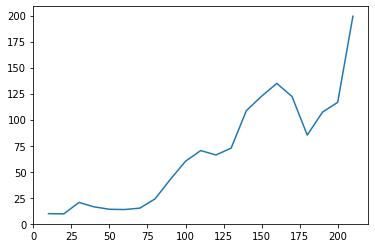

In [ ]:
%%time
# Running the training and evaluation
pms = Parameters()
dqn = Dqn(pms)
ep_ids, returns = dqn.train_function()
plt.plot(ep_ids, returns)
dqn.evaluation(video=False)
dqn.close()

### Question:

* Does it converge all the time?

 > No it does not converge all the time. We are in stage of exploration and exploitation where we need to find the  <code style="background:yellow;color:black">optimal policy(q_)</code>. Here we do a important observation that we reach a score of 200 at **episode ID 200**.

 > Convergence in this case is only possible with right set of parameters and with proper iterations as we observe there is a optimal point where the loss function is at local minima with proper weights


* What happens if you change the default parameters?

> The art of intelligent parameter selection and tuning leads to convergence and we tune the following params. We will only try to tune in parameters which are part of training process not the q-value function.

1. Frequency of frozen network: Let's observe in high and low values of C

Initialization was finished.
Training was started.
Episode Id: 10 Return during training: 55.0
Episode Id: 20 Return during training: 145.0
Episode Id: 30 Return during training: 168.0
Episode Id: 40 Return during training: 129.0
Episode Id: 50 Return during training: 83.0
Episode Id: 60 Return during training: 200.0
Episode Id: 70 Return during training: 82.0
Episode Id: 80 Return during training: 53.0
Episode Id: 90 Return during training: 200.0
Episode Id: 100 Return during training: 26.0
Episode Id: 110 Return during training: 116.0
Episode Id: 120 Return during training: 38.0
Episode Id: 130 Return during training: 119.0
Episode Id: 140 Return during training: 53.0
Episode Id: 150 Return during training: 26.0
Episode Id: 160 Return during training: 42.0
Episode Id: 170 Return during training: 24.0
Training was finished.


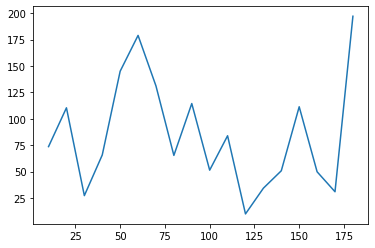

In [ ]:
# Low C = 1
# In this case we lower the learning rate as well
class Parameters:

    def __init__(self):
                                 # Default values
        self.buf_size = 5000     # 5000
        self.batch = 256         # 256
        self.epoch = 5           # 5
        self.max_ep = 500        # 500
        self.eps = 0.2           # 0.2
        self.gamma = 0.9         # 0.9
        self.C = 1               # 1
        self.train_freq = 1      # 1
        self.eval_freq = 10      # 10
        self.net = [(128, 'relu'), (128, 'relu'), (2, 'relu')] # [(128, 'relu'), (128, 'relu'), (2, 'relu')]
        self.lr = 0.01         # 0.0001
        self.opt = Optimizer.ADAM # Optimizer.ADAM

# Running the training and evaluation
pms = Parameters()
dqn = Dqn(pms)
ep_ids, returns = dqn.train_function()
plt.plot(ep_ids, returns)
dqn.evaluation(video=False)
dqn.close()

Initialization was finished.
Training was started.
Episode Id: 10 Return during training: 18.0
Episode Id: 20 Return during training: 12.0
Episode Id: 30 Return during training: 13.0
Episode Id: 40 Return during training: 11.0
Episode Id: 50 Return during training: 8.0
Episode Id: 60 Return during training: 17.0
Episode Id: 70 Return during training: 9.0
Episode Id: 80 Return during training: 10.0
Episode Id: 90 Return during training: 17.0
Episode Id: 100 Return during training: 11.0
Episode Id: 110 Return during training: 54.0
Episode Id: 120 Return during training: 11.0
Episode Id: 130 Return during training: 10.0
Episode Id: 140 Return during training: 28.0
Episode Id: 150 Return during training: 37.0
Episode Id: 160 Return during training: 10.0
Episode Id: 170 Return during training: 31.0
Episode Id: 180 Return during training: 66.0
Episode Id: 190 Return during training: 97.0
Episode Id: 200 Return during training: 112.0
Episode Id: 210 Return during training: 107.0
Episode Id: 2

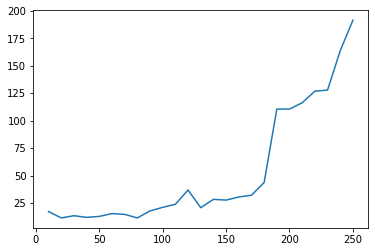

In [16]:
# High C = 1000
class Parameters:

    def __init__(self):
                                 # Default values
        self.buf_size = 5000     # 5000
        self.batch = 256         # 256
        self.epoch = 5           # 5
        self.max_ep = 500        # 500
        self.eps = 0.2           # 0.5
        self.gamma = 0.9         # 0.9
        self.C = 1000            # 1000
        self.train_freq = 1      # 1
        self.eval_freq = 10      # 10
        self.net = [(128, 'relu'), (128, 'relu'), (2, 'relu')] # [(128, 'relu'), (128, 'relu'), (2, 'relu')]
        self.lr = 0.0001         # 0.0001
        self.opt = Optimizer.ADAM # Optimizer.ADAM

# Running the training and evaluation
pms = Parameters()
dqn = Dqn(pms)
ep_ids, returns = dqn.train_function()
plt.plot(ep_ids, returns)
dqn.evaluation(video=False)
dqn.close()

**OBSERVATIONS**
<div class="alert alert-block alert-warning">

We attain very high score quickly, with low C value but in the case of high C value we see it takes time to converge which implies high exploration.

</div>

2. Neural network parameters : We try to tune in training parameters of neural network like dense size and check if at all there is an impact due to this.

Initialization was finished.
Training was started.
Episode Id: 10 Return during training: 9.0
Episode Id: 20 Return during training: 11.0
Episode Id: 30 Return during training: 9.0
Episode Id: 40 Return during training: 11.0
Episode Id: 50 Return during training: 13.0
Episode Id: 60 Return during training: 11.0
Episode Id: 70 Return during training: 9.0
Episode Id: 80 Return during training: 11.0
Episode Id: 90 Return during training: 10.0
Episode Id: 100 Return during training: 16.0
Episode Id: 110 Return during training: 9.0
Episode Id: 120 Return during training: 17.0
Episode Id: 130 Return during training: 23.0
Episode Id: 140 Return during training: 41.0
Episode Id: 150 Return during training: 70.0
Episode Id: 160 Return during training: 57.0
Episode Id: 170 Return during training: 92.0
Episode Id: 180 Return during training: 116.0
Episode Id: 190 Return during training: 111.0
Episode Id: 200 Return during training: 126.0
Training was finished.


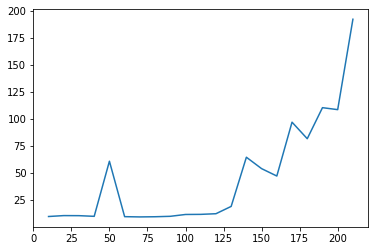

In [ ]:
# Weights and we lower the epochs 
class Parameters:

    def __init__(self):
                                 # Default values
        self.buf_size = 5000     # 5000
        self.batch = 256         # 256
        self.epoch = 3           # 1
        self.max_ep = 500        # 500
        self.eps = 0.2           # 0.5
        self.gamma = 0.9         # 0.9
        self.C = 1000            # 100
        self.train_freq = 1      # 1
        self.eval_freq = 10      # 10
        self.net = [(512, 'relu'), (256, 'relu'), (2, 'relu')] # [(512, 'relu'), (256, 'relu'), (2, 'relu')]
        self.lr = 0.0001         # 0.0001
        self.opt = Optimizer.ADAM # Optimizer.ADAM
# Running the training and evaluation
pms = Parameters()
dqn = Dqn(pms)
ep_ids, returns = dqn.train_function()
plt.plot(ep_ids, returns)
dqn.evaluation(video=False)
dqn.close()

**OBSERVATIONS**
<div class="alert alert-block alert-warning">

It does not reach optimal value and changing the weights does not impact the convergence at all.

</div>

3. Optimizers like RMS prop and SGD

Initialization was finished.
Training was started.
Episode Id: 10 Return during training: 11.0
Episode Id: 20 Return during training: 10.0
Episode Id: 30 Return during training: 10.0
Episode Id: 40 Return during training: 9.0
Episode Id: 50 Return during training: 9.0
Episode Id: 60 Return during training: 10.0
Episode Id: 70 Return during training: 9.0
Episode Id: 80 Return during training: 9.0
Episode Id: 90 Return during training: 9.0
Episode Id: 100 Return during training: 10.0
Episode Id: 110 Return during training: 9.0
Episode Id: 120 Return during training: 10.0
Episode Id: 130 Return during training: 11.0
Episode Id: 140 Return during training: 9.0
Episode Id: 150 Return during training: 11.0
Episode Id: 160 Return during training: 9.0
Episode Id: 170 Return during training: 9.0
Episode Id: 180 Return during training: 10.0
Episode Id: 190 Return during training: 12.0
Episode Id: 200 Return during training: 10.0
Episode Id: 210 Return during training: 10.0
Episode Id: 220 Return

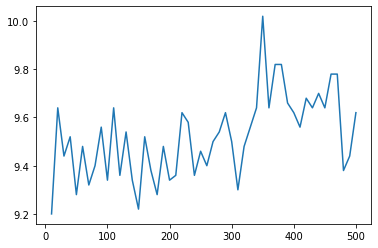

In [ ]:
%%time
# optimizer = SGD and we make the learning rate hight too
class Parameters:

    def __init__(self):
                                 # Default values
        self.buf_size = 5000     # 5000
        self.batch = 256         # 256
        self.epoch = 5           # 5
        self.max_ep = 500        # 500
        self.eps = 0.2           # 0.2
        self.gamma = 0.9         # 0.9
        self.C = 100             # 100
        self.train_freq = 10     # 10
        self.eval_freq = 10      # 10
        self.net = [(256, 'relu'), (256, 'relu'), (2, 'relu')] # [(128, 'relu'), (128, 'relu'), (2, 'relu')]
        self.lr = 0.01         # 0.01
        self.opt = Optimizer.SGD # Optimizer.SGD

# Running the training and evaluation
pms = Parameters()
dqn = Dqn(pms)
ep_ids, returns = dqn.train_function()
plt.plot(ep_ids, returns)
dqn.evaluation(video=False)
dqn.close()

Initialization was finished.
Training was started.
Episode Id: 10 Return during training: 10.0
Episode Id: 20 Return during training: 10.0
Episode Id: 30 Return during training: 10.0
Episode Id: 40 Return during training: 10.0
Episode Id: 50 Return during training: 10.0
Episode Id: 60 Return during training: 10.0
Episode Id: 70 Return during training: 24.0
Episode Id: 80 Return during training: 10.0
Episode Id: 90 Return during training: 13.0
Episode Id: 100 Return during training: 34.0
Episode Id: 110 Return during training: 52.0
Episode Id: 120 Return during training: 110.0
Episode Id: 130 Return during training: 95.0
Episode Id: 140 Return during training: 111.0
Episode Id: 150 Return during training: 200.0
Episode Id: 160 Return during training: 150.0
Episode Id: 170 Return during training: 64.0
Episode Id: 180 Return during training: 55.0
Episode Id: 190 Return during training: 48.0
Episode Id: 200 Return during training: 16.0
Episode Id: 210 Return during training: 32.0
Episode I

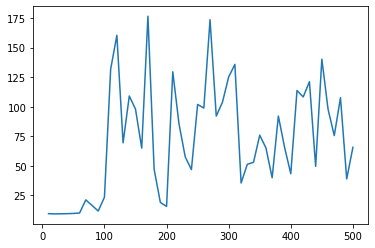

In [ ]:
%%time
# optimizer = RMS
class Parameters:

    def __init__(self):
                                 # Default values
        self.buf_size = 5000     # 5000
        self.batch = 256         # 256
        self.epoch = 5           # 5
        self.max_ep = 500        # 500
        self.eps = 0.2           # 0.2
        self.gamma = 0.9         # 0.9
        self.C = 100             # 100
        self.train_freq = 10      # 10
        self.eval_freq = 10      # 10
        self.net = [(256, 'relu'), (256, 'relu'), (2, 'relu')] # [(256, 'relu'), (256, 'relu'), (2, 'relu')]
        self.lr = 0.01         # 0.01
        self.opt = Optimizer.RMSPROP # Optimizer.RMS

# Running the training and evaluation
pms = Parameters()
dqn = Dqn(pms)
ep_ids, returns = dqn.train_function()
plt.plot(ep_ids, returns)
dqn.evaluation(video=False)
dqn.close()

**OBSERVATIONS**
<div class="alert alert-block alert-warning">

Generally when we select right frequency with proper learning rate we see there is an impact in convergence by RMSPROP.

</div>

<div class="alert alert-block alert-success">
<b>Key takeaways:</b>
 Carefully training a DQN function plays an important role in convergence and selecting this leads to <code style="background:yellow;color:black">better optimization and convergence.</code>.
</div>